# Classifier based on beta-band

## Looking at TFR

In [2]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import mne

data_dir = "./data/digits_epochs/"
file = data_dir + "freq_bands/all_data_all_epochs.pkl"
all_epochs = pickle.load(open(file, "rb")).pick(picks="meg", exclude="bads")
all_epochs = all_epochs.decimate(2)

In [3]:
labels = np.unique(all_epochs.events[:, -1])
fmin = 12.5
fmax = 30
freqs = np.arange(fmin, fmax + 1, 2)
n_cycles = freqs / 2  # different number of cycle per frequency

if os.path.exists(data_dir + "all_epochs_tfr_beta.pkl"):
    with open(data_dir + "all_epochs_tfr_beta.pkl", "rb") as f:
        power = pickle.load(f)
else:
    power = {}
    for idx, label in enumerate(labels):
        valid_epochs_mask = np.isin(all_epochs.events[:, -1], label)
        label_epochs = all_epochs[valid_epochs_mask]

        power[idx + 1] = mne.time_frequency.tfr_morlet(
            label_epochs,
            freqs=freqs,
            n_cycles=n_cycles,
            n_jobs=1,
            return_itc=False,
            decim=3,
        )
    with open(data_dir + "all_epochs_tfr_beta.pkl", "wb") as f:
        pickle.dump(power, f)


## Plotting TFR


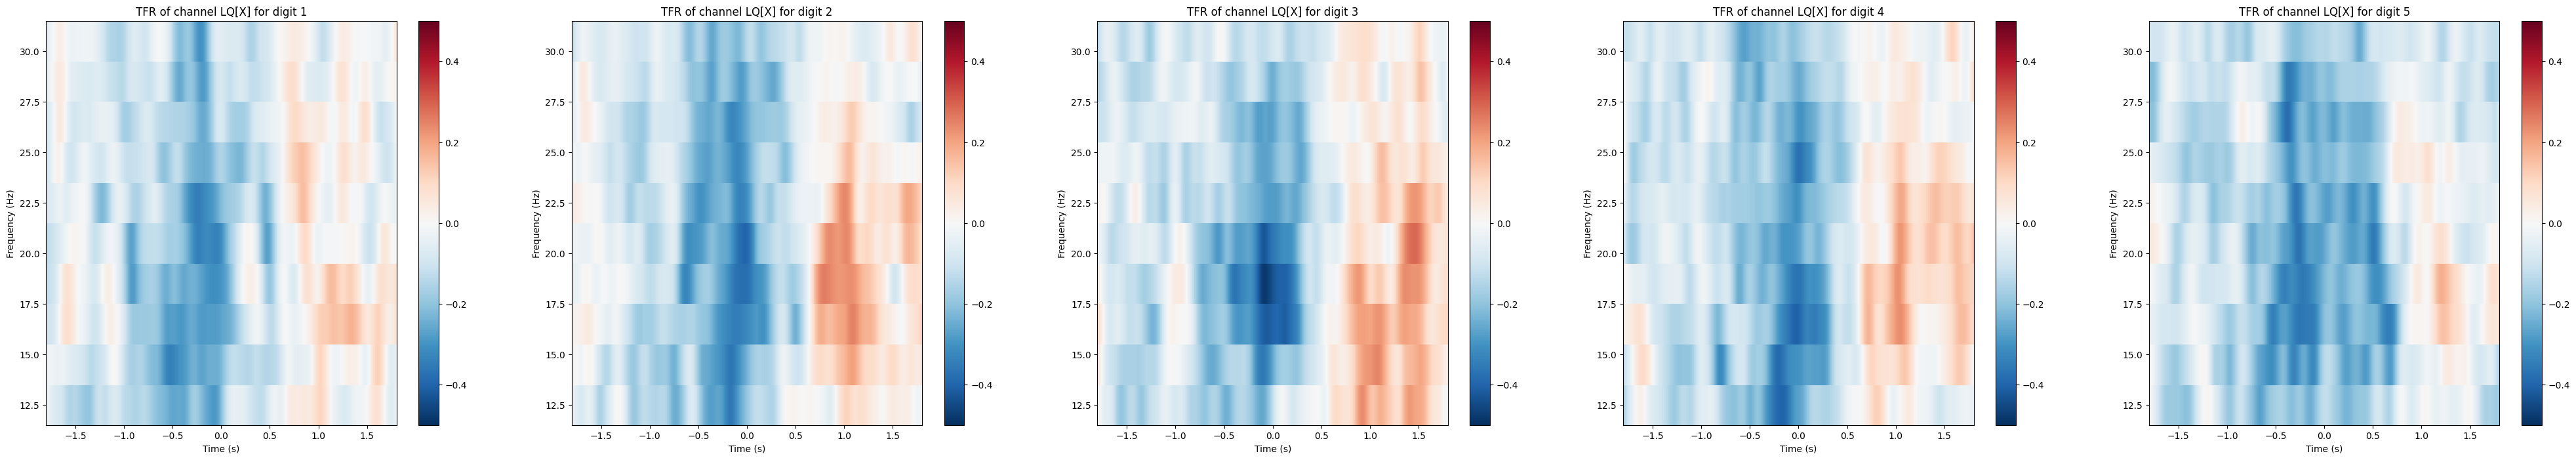

In [4]:
channel1 = "LQ[X]"
idx_channel = all_epochs.ch_names.index(channel1)

conditions = [1, 2, 3, 4, 5]
# Create a figure with subplots
fig, axes = plt.subplots(
    1, len(conditions), figsize=(50, 8)
)  # Adjust figsize as needed

for i, condition in enumerate(conditions):
    # Select the subplot
    ax = axes[i]

    # Plot the 5 different digits in a subplot horziontally
    power[condition].plot(
        [idx_channel],
        baseline=(-2, -0.57),
        mode="logratio",
        tmin=-1.8,
        tmax=1.8,
        axes=ax,
        show=False,
        vmin=-0.5,
        verbose=False,
        vmax=0.5,
    )
    ax.set_title("TFR of channel " + channel1 + " for digit " + str(i + 1))

In [5]:
# Function that takes a array and givees the indices where the absolute value is lower than 1.8
def find_indices(array, threshold=1.8):
    indices = []
    for idx, value in enumerate(array):
        if np.abs(value) < threshold:
            indices.append(idx)
    return indices

In [6]:
from mne.baseline import rescale

power_scaled = []

for i in range(5):
    data = power[i + 1].data
    times = power[i + 1].times
    baseline = (-2, -0.57)
    data = rescale(data, times, baseline, mode="logratio", verbose=False)
    if np.iscomplexobj(data):
        data = (data * data.conj()).real
    time_indices = find_indices(times, threshold=1.75)
    times = times[time_indices]
    data = data.mean(axis=1)
    power_scaled.append(data[:, time_indices])

power_scaled = np.array(power_scaled)
variance = np.var(power_scaled[:], axis=2)
mean = np.mean(power_scaled[:], axis=2)
highest_variance = np.argmax(variance, axis=0) + 1

In [11]:
power_scaled.max()

1.4775043294434533

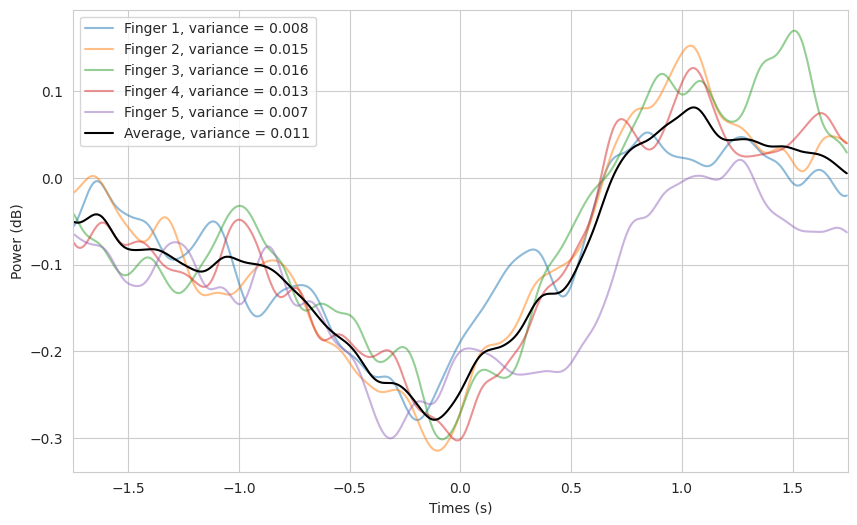

Highest variance in condition: 3


In [21]:
import seaborn as sns
import pandas as pd
channel1 = "LQ[X]"
channel2 = "FY[Y]"
channel3 = "HQ[Z]"
idx_channel = all_epochs.ch_names.index(channel1)

data_list = []

sns.set_style("whitegrid")

# Create the line plot with confidence interval
plt.figure(figsize=(10, 6))
num = 0
conditions = [1, 2, 3, 4, 5]
# Plot the lineplot of all digits
for i, condition in enumerate(conditions):
    # Do a low pass filter of the power np.array
    power_beta = power_scaled[condition - 1][idx_channel]
    df = pd.DataFrame({"Power": power_beta})
    df["Times"] = times
    num += 1
    opacity = 0.5
    lineplot = sns.lineplot(
        data=df,
        x="Times",
        y="Power",
        label=f"Finger {condition}, variance = {np.var(power_beta):.3f}",
        alpha=opacity,
    )
    xlim = (-1.75, 1.75)
    lineplot.set_xlabel("Times (s)")
    lineplot.set_ylabel("Power (dB)")
    lineplot.set(xlim=xlim)
    ylim = (-0.5, 0.3)
    # Add legend
lineplot.legend()
average_df = df
average_df["Power"] = power_scaled.mean(axis=0)[idx_channel]
lineplot = sns.lineplot(
    data=average_df,
    x="Times",
    y="Power",
    label=f"Average, variance = {np.var(power_scaled.mean(axis=0)[idx_channel]):.3f}",
    alpha=1,
    color="black",
)
plt.show()
print("Highest variance in condition:", highest_variance[idx_channel])

### Put again together the classifier on Hilbert transformed on the ACTUAL envelope of the Hilbert Transform. Try on smaller bins (15-20)
